In [47]:
import bagpy
from bagpy import bagreader
from datetime import datetime
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
import logging
import re
import os
import math

In [2]:
child_w1_df = pd.read_csv('1_EXP05_Full/week_1/child.csv').iloc[: , 1:]
child_w4_df = pd.read_csv('1_EXP05_Full/week_4/child.csv').iloc[: , 1:]

FileNotFoundError: [Errno 2] No such file or directory: '1_EXP05_Full/week_4/child.csv'

## Markov Chain

In [4]:
# outside = outside pre-defined boxes
# nodetection = openCV cannot find eyes
# screen, robot, parent

def transition_matrix(transitions, order=-1):
    df = pd.DataFrame(transitions)
    
    # create a new column with data shifted one space
    df['shift'] = df[0].shift(order)

    # add a count column (for group by function)
    df['count'] = 1

    # groupby and then unstack, fill the zeros
    trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

    # normalise by occurences and save values to get transition matrix
    trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0).values
    labels = np.unique(transitions)
    
    return trans_mat, labels

In [5]:
transitions_w1 = np.asarray(child_w1_df[child_w1_df['object'] != 'nodetection']['object'])
transitions_w4 = np.asarray(child_w4_df[child_w4_df['object'] != 'nodetection']['object'])

trans_mat_w1, labels_w1 = transition_matrix(transitions_w1, order=-1)
trans_mat_w4, labels_w4 = transition_matrix(transitions_w4, order=-1)

In [6]:
# x-axis = next state
# y-axis = current state

print(trans_mat_w1, labels_w1)
print(trans_mat_w4, labels_w4)

[[0.33606557 0.00409836 0.04918033 0.61065574]
 [0.66666667 0.33333333 0.         0.        ]
 [0.2027027  0.         0.18918919 0.60810811]
 [0.34688995 0.00239234 0.11483254 0.53588517]] ['outside' 'parent' 'robot' 'screen']
[[0.2        0.00656934 0.06642336 0.7270073 ]
 [0.15384615 0.17948718 0.38461538 0.28205128]
 [0.15445026 0.02225131 0.19895288 0.62434555]
 [0.33586469 0.00207111 0.17466344 0.48740076]] ['outside' 'parent' 'robot' 'screen']


In [7]:
def KL(P,Q):
     epsilon = 0.00001
     P = P+epsilon
     Q = Q+epsilon

     divergence = np.sum(P*np.log(P/Q))
     return divergence

print('\nKL(week 1 || week 4): ')
for i in range(0, len(trans_mat_w1)):
    print(labels_w1[i], KL(trans_mat_w1[i], trans_mat_w4[i]))

print('\nKL(week 4 || week 1): ')
for i in range(0, len(trans_mat_w1)):
    print(labels_w4[i], KL(trans_mat_w4[i], trans_mat_w1[i]))


KL(week 1 || week 4): 
outside 0.05119579032370833
parent 1.1836753512630664
robot 0.02948639608143425
screen 0.01420883668398295

KL(week 4 || week 1): 
outside 0.04605493955574122
parent 6.614315999567413
robot 0.15606386867094638
screen 0.01588168023953932


## ANOVA on Gaze

In [181]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})

### Data Processing

In [182]:
PID = '1_EXP05_Full/'

In [183]:
# read data
df_c_w1 = pd.read_csv(PID + 'week_1/' + 'child.csv')
df_c_w2 = pd.read_csv(PID + 'week_2/' + 'child.csv')
df_c_w3 = pd.read_csv(PID + 'week_3/' + 'child.csv')
df_c_w4 = pd.read_csv(PID + 'week_4/' + 'child.csv')

In [184]:
# remove rows where the duration is 0
df_c_w1 = df_c_w1[df_c_w1['duration'] != 0]
df_c_w2 = df_c_w2[df_c_w2['duration'] != 0]
df_c_w3 = df_c_w3[df_c_w3['duration'] != 0]
df_c_w4 = df_c_w4[df_c_w4['duration'] != 0]

In [177]:
# remove outliers
df_c_w1 = df_c_w1[(np.abs(stats.zscore(df_c_w1['duration'])) < 3)].reset_index()
df_c_w2 = df_c_w2[(np.abs(stats.zscore(df_c_w2['duration'])) < 3)].reset_index()
df_c_w3 = df_c_w3[(np.abs(stats.zscore(df_c_w3['duration'])) < 3)].reset_index()
df_c_w4 = df_c_w4[(np.abs(stats.zscore(df_c_w4['duration'])) < 3)].reset_index()

In [185]:
# determine unique days in dataset
_, unique_days_w1 = get_unique_days(df_c_w1['start'])
_, unique_days_w2 = get_unique_days(df_c_w2['start'])
_, unique_days_w3 = get_unique_days(df_c_w3['start'])
_, unique_days_w4 = get_unique_days(df_c_w4['start'])

unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
print(unique_days)

[ 7 10 11 14 16 17 18 20 21 22 23 25 27 28  2  3  4  5  6  7  8 29 30 31]


In [186]:
# set day (of study) identifier
df_c_w1['day'] = df_c_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
df_c_w2['day'] = df_c_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
df_c_w3['day'] = df_c_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
df_c_w4['day'] = df_c_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

In [187]:
# set week identifier
df_c_w1['week'] = 1
df_c_w2['week'] = 2
df_c_w3['week'] = 3
df_c_w4['week'] = 4

In [188]:
# apply data transform
df_c_w1['log_duration'] = df_c_w1['duration'].apply(lambda x: math.log(x))
df_c_w2['log_duration'] = df_c_w2['duration'].apply(lambda x: math.log(x))
df_c_w3['log_duration'] = df_c_w3['duration'].apply(lambda x: math.log(x))
df_c_w4['log_duration'] = df_c_w4['duration'].apply(lambda x: math.log(x))

In [189]:
# remove index
df_c_w1 = df_c_w1.iloc[:, 1:]
df_c_w2 = df_c_w2.iloc[:, 1:]
df_c_w3 = df_c_w3.iloc[:, 1:]
df_c_w4 = df_c_w4.iloc[:, 1:]

In [190]:
# check table formatting
df_c_w1

,object,duration,start,day,week,log_duration
0,nodetection,14.193398,1.499458e+09,0,1,2.652777
1,outside,22.588879,1.499458e+09,0,1,3.117458
2,nodetection,0.599435,1.499458e+09,0,1,-0.511768
3,outside,0.099960,1.499458e+09,0,1,-2.302987
4,nodetection,0.399282,1.499458e+09,0,1,-0.918088
...,...,...,...,...,...,...
1252,outside,0.900717,1.500052e+09,3,1,-0.104564
1253,nodetection,0.999582,1.500052e+09,3,1,-0.000418
1254,screen,2.700183,1.500052e+09,3,1,0.993319
1255,nodetection,5.200912,1.500052e+09,3,1,1.648834


In [ ]:
# combine all week dataframes
frames = [df_c_w1, df_c_w2, df_c_w3, df_c_w4]
df_c = pd.concat(frames)
df_c

### Plots

In [204]:
# which object are we looking at?
obj = 'parent'

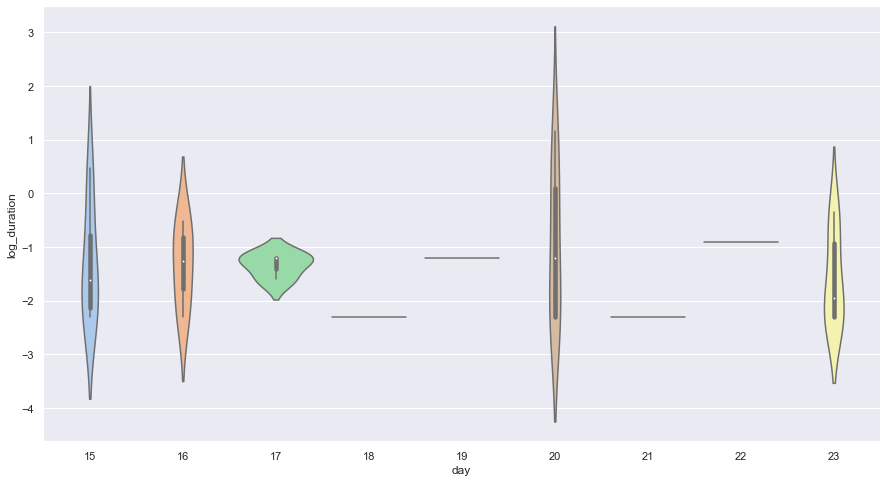

In [241]:
# example daily analysis, one week
ax = sns.violinplot(x="day", y="log_duration", data=df_c_w4[df_c_w4['object'] == obj], palette="pastel")

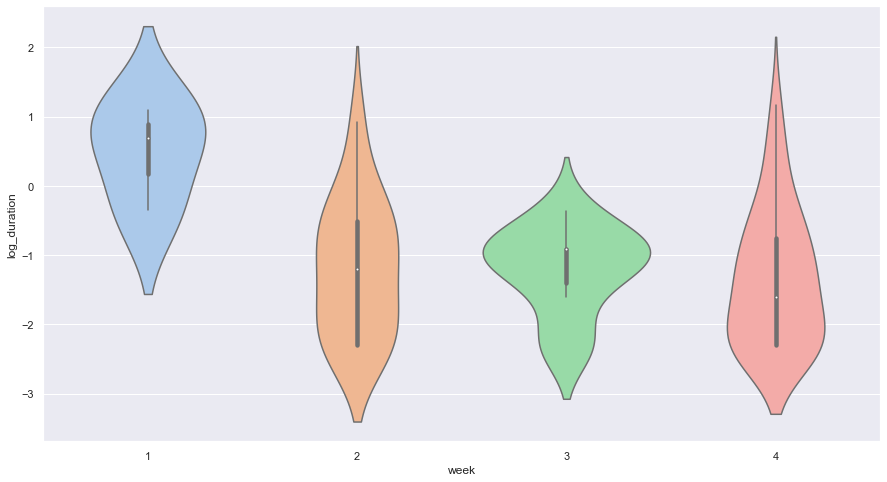

In [243]:
# example weekly analysis, entire study
ax = sns.violinplot(x="week", y="log_duration", data=df_c[df_c['object'] == obj], palette="pastel")

### One-Way ANOVA

In [209]:
df_c_summary = pd.DataFrame({
    'Week 1': df_c_w1[df_c_w1['object'] == obj]['duration'], 
    'Week 2': df_c_w2[df_c_w2['object'] == obj]['duration'], 
    'Week 3': df_c_w3[df_c_w3['object'] == obj]['duration'], 
    'Week 4': df_c_w4[df_c_w4['object'] == obj]['duration']
})

In [210]:
df_c_summary.describe()

,Week 1,Week 2,Week 3,Week 4
count,3.000000,17.000000,11.000000,30.000000
mean,1.900031,0.488267,0.345446,0.453369
std,1.153088,0.590408,0.175254,0.642602
min,0.700276,0.099984,0.099974,0.099860
25%,1.350066,0.100104,0.249988,0.100041
50%,1.999855,0.300083,0.399939,0.200379
75%,2.499909,0.600007,0.400044,0.475112
max,2.999963,2.499989,0.699807,3.200118


In [211]:
# one-way ANOVA, check if model is significant
F, p = stats.f_oneway(
    df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c_w4[df_c_w4['object'] == obj]['duration']
)

print('F-Statistic=%.3f, p=%.3f' % (F, p))

# if we see that p-value is < 0.05. 
# we can reject the null hypothesis which states that there is no difference among the different density groups

F-Statistic=5.739, p=0.002


In [212]:
# one-way ANOVA, regress against each input variable to check influence over the target variable
model = ols('log_duration ~ C(week)', df_c[df_c['object'] == obj]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3.611
Date:                Wed, 16 Mar 2022   Prob (F-statistic):             0.0185
Time:                        19:34:54   Log-Likelihood:                -79.022
No. Observations:                  61   AIC:                             166.0
Df Residuals:                      57   BIC:                             174.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4785      0.528      0.906      0.369      -0.579       1.536
C(week)[T.2]    -1.6715      0.573     -2.919      0.005      -2.818      -0.525
C(week)[T.3]    -1.6910      0.596     -2.839      0.006      -2.883      -0.498
C(week)[T.4]    -1.8210      0.554     -3.289      0.002      -2.930      -0.712
==============================================================================
Omnibus:                        3.958   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                3.653
Skew:                           0.598   Prob(JB):                        0.161
Kurtosis:                       2.908   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
# check if overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 3, 57) =  3.611, p =  0.0185


In [214]:
# create the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

# from the output, we see that the p  >0.05. 
# Therefore, we cannot reject the null hypothesis. 
# There is no difference among the different weeks

,sum_sq,df,F,PR(>F)
C(week),9.054992,3.0,3.610615,0.018549
Residual,47.649732,57.0,NaN,NaN


### Post Hoc

In [240]:
# tukey hsd test to examine where the group differences lie
mc = statsmodels.stats.multicomp.MultiComparison(df_c['log_duration'], df_c['week'])
mc_results = mc.tukeyhsd()
print(mc_results)

# where reject = True, there is a significant difference between the groups

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.2059  0.001 -0.3259 -0.0859   True
     1      3  -0.2604  0.001  -0.378 -0.1429   True
     1      4  -0.4296  0.001 -0.5372  -0.322   True
     2      3  -0.0545 0.4539 -0.1495  0.0404  False
     2      4  -0.2237  0.001 -0.3061 -0.1414   True
     3      4  -0.1692  0.001 -0.2479 -0.0904   True
----------------------------------------------------


In [219]:
# normality assumption check using shapiro wilk test
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

# if the p-value >0.05
# we can conclude that our data follows the gaussian distribution
# else, it doesn't follow the assumptions of the ANOVA model

0.9263902902603149 0.0012629823759198189


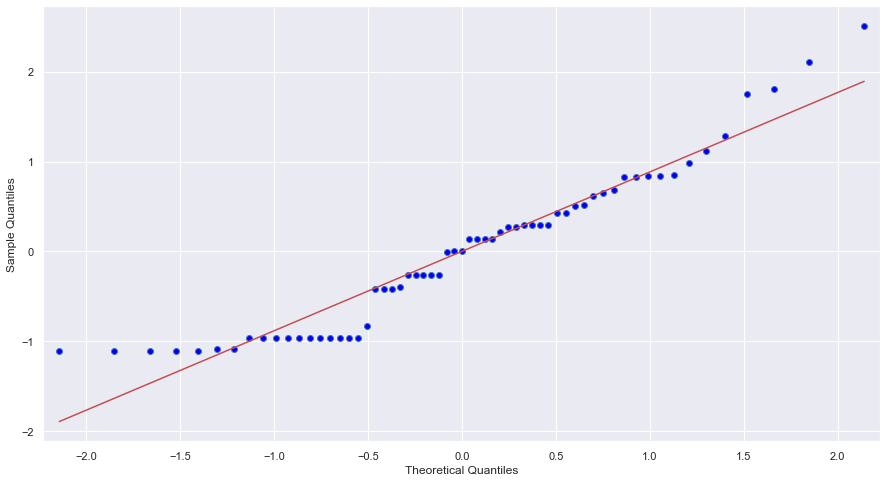

In [221]:
# using the Normal Q-Q plot to test this assumption
res = model.resid
fig = sm.qqplot(res, line='s')
plt.show()

# if we see that all data points lie close to the 45-degree line
# we can conclude it follows the normal distribution

In [227]:
# homogeneity of variance assumption check

# Bartlett variance test, Method 1
wb, pb = stats.bartlett(
    df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c_w4[df_c_w4['object'] == obj]['duration']
)
print('Bartlett variance test: w=%.3f, p=%.3f' % (wb, pb))

# Levene variance test, Method 2
wl, pl = stats.levene(
    df_c_w1[df_c_w1['object'] == obj]['duration'], 
    df_c_w2[df_c_w2['object'] == obj]['duration'], 
    df_c_w3[df_c_w3['object'] == obj]['duration'], 
    df_c_w4[df_c_w4['object'] == obj]['duration']
)
print('Levene variance test: w=%.3f, p=%.3f' % (wl, pl))

# if we see p > 0.05 for all weeks
# we can conclude that groups have equal variances

Bartlett variance test: w=17.234, p=0.001
Levene variance test: w=1.207, p=0.316


### Two-Way ANOVA

In [229]:
model2 = ols('log_duration ~ C(week)+ C(object)', df_c).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     84.35
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          2.02e-120
Time:                        19:51:39   Log-Likelihood:                -21445.
No. Observations:               12622   AIC:                         4.291e+04
Df Residuals:                   12614   BIC:                         4.297e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1081      0.041     -2.665      0.008      -0.188      -0.029
C(week)[T.2]            -0.1785      0.046     -3.877      0.000      -0.269      -0.088
C(week)[T.3]            -0.2517      0.045     -5.574      0.000      -0.340      -0.163
C(week)[T.4]            -0.4281      0.041    -10.350      0.000      -0.509      -0.347
C(object)[T.outside]    -0.4860      0.034    -14.168      0.000      -0.553      -0.419
C(object)[T.parent]     -0.7741      0.171     -4.528      0.000      -1.109      -0.439
C(object)[T.robot]      -0.3294      0.044     -7.434      0.000      -0.416      -0.243
C(object)[T.screen]      0.1364      0.029      4.725      0.000       0.080       0.193
==============================================================================
Omnibus:                     2931.050   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16873.130
Skew:                           0.992   Prob(JB):                         0.00
Kurtosis:                       8.305   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [230]:
print(f"Overall model F({model2.df_model: },{model2.df_resid: }) = {model2.fvalue: }, p = {model2.f_pvalue: }")

Overall model F( 7.0, 12614.0) =  84.34829085661737, p =  2.0245205635809637e-120


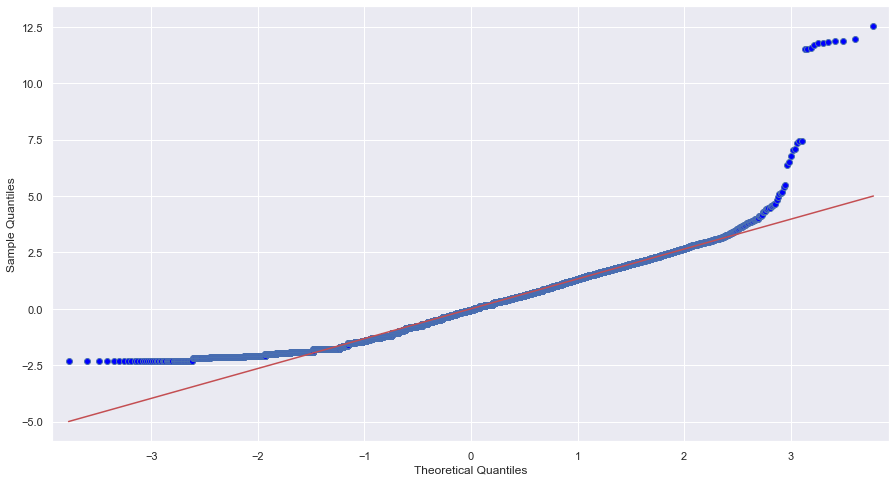

In [232]:
# create the ANOVA table
res2 = sm.stats.anova_lm(model2, typ=2)
res2

# check the Normal distribution of residuals
res = model2.resid
fig = sm.qqplot(res, line='s')
plt.show()

# from the Q-Q plot, we can see that residuals are almost normally distributed
# (although points at the extreme ends can be discounted)
# hence we conclude that it satisfies the normality assumption of the ANOVA test

In [234]:
# check the interaction of groups
formula = 'log_duration ~ C(week) *C(object)'
model = ols(formula, df_c).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     47.80
Date:                Wed, 16 Mar 2022   Prob (F-statistic):          7.01e-174
Time:                        19:53:36   Log-Likelihood:                -21295.
No. Observations:               12622   AIC:                         4.263e+04
Df Residuals:                   12602   BIC:                         4.278e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.4962      0.058      8.596      0.000       0.383       0.609
C(week)[T.2]                         -0.6098      0.076     -7.972      0.000      -0.760      -0.460
C(week)[T.3]                         -0.9813      0.075    -13.027      0.000      -1.129      -0.834
C(week)[T.4]                         -1.2371      0.066    -18.705      0.000      -1.367      -1.107
C(object)[T.outside]                 -1.1827      0.102    -11.577      0.000      -1.383      -0.982
C(object)[T.parent]                  -0.0177      0.758     -0.023      0.981      -1.503       1.468
C(object)[T.robot]                   -1.3492      0.163     -8.292      0.000      -1.668      -1.030
C(object)[T.screen]                  -1.0966      0.086    -12.707      0.000      -1.266      -0.927
C(week)[T.2]:C(object)[T.outside]     0.4837      0.126      3.849      0.000       0.237       0.730
C(week)[T.3]:C(object)[T.outside]     0.7717      0.125      6.170      0.000       0.527       1.017
C(week)[T.4]:C(object)[T.outside]     0.9691      0.114      8.503      0.000       0.746       1.193
C(week)[T.2]:C(object)[T.parent]     -1.0617      0.823     -1.290      0.197      -2.675       0.552
C(week)[T.3]:C(object)[T.parent]     -0.7096      0.856     -0.829      0.407      -2.387       0.968
C(week)[T.4]:C(object)[T.parent]     -0.5839      0.795     -0.734      0.463      -2.143       0.975
C(week)[T.2]:C(object)[T.robot]       0.7234      0.192      3.761      0.000       0.346       1.100
C(week)[T.3]:C(object)[T.robot]       1.1867      0.187      6.341      0.000       0.820       1.553
C(week)[T.4]:C(object)[T.robot]       1.2965      0.174      7.460      0.000       0.956       1.637
C(week)[T.2]:C(object)[T.screen]      0.9941      0.108      9.187      0.000       0.782       1.206
C(week)[T.3]:C(object)[T.screen]      1.4495      0.106     13.702      0.000       1.242       1.657
C(week)[T.4]:C(object)[T.screen]      1.5208      0.096     15.898      0.000       1.333       1.708
==============================================================================
Omnibus:                     3011.823   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18330.981
Skew:                           1.006   Prob(JB):                         0.00
Kurtosis:                       8.550   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
from statsmodels.stats.anova import anova_lm
aov_table = anova_lm(model, typ=2)
print(aov_table.round(4))

                       sum_sq       df         F  PR(>F)
C(week)              252.9234      3.0   49.2295     0.0
C(object)            794.5607      4.0  115.9911     0.0
C(week):C(object)    520.6585     12.0   25.3355     0.0
Residual           21581.5233  12602.0       NaN     NaN


In [239]:
mc = statsmodels.stats.multicomp.MultiComparison(df_c['log_duration'], df_c['object'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1    group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------------
nodetection outside   -0.492  0.001 -0.5859 -0.3981   True
nodetection  parent  -0.7971  0.001  -1.266 -0.3282   True
nodetection   robot  -0.3633  0.001 -0.4844 -0.2421   True
nodetection  screen   0.1136  0.001  0.0347  0.1925   True
    outside  parent  -0.3051 0.3929 -0.7756  0.1653  False
    outside   robot   0.1287 0.0449  0.0018  0.2556   True
    outside  screen   0.6056  0.001  0.5182   0.693   True
     parent   robot   0.4339 0.0943 -0.0428  0.9105  False
     parent  screen   0.9107  0.001  0.4431  1.3784   True
      robot  screen   0.4769  0.001  0.3606  0.5931   True
----------------------------------------------------------


## ANOVA on Joint Attention

In [3]:
from scipy import stats
import statsmodels.api as sm

In [4]:
PID = '1_EXP05_Full/'

In [5]:
# read from existing files
df_cr_w1 = pd.read_csv(PID + 'week_1/' + 'child-robot.csv')
df_cp_w1 = pd.read_csv(PID + 'week_1/' + 'child-parent.csv')
df_pr_w1 = pd.read_csv(PID + 'week_1/' + 'parent-robot.csv')

df_cr_w2 = pd.read_csv(PID + 'week_2/' + 'child-robot.csv')
df_cp_w2 = pd.read_csv(PID + 'week_2/' + 'child-parent.csv')
df_pr_w2 = pd.read_csv(PID + 'week_2/' + 'parent-robot.csv')

df_cr_w3 = pd.read_csv(PID + 'week_3/' + 'child-robot.csv')
df_cp_w3 = pd.read_csv(PID + 'week_3/' + 'child-parent.csv')
df_pr_w3 = pd.read_csv(PID + 'week_3/' + 'parent-robot.csv')

df_cr_w4 = pd.read_csv(PID + 'week_4/' + 'child-robot.csv')
df_cp_w4 = pd.read_csv(PID + 'week_4/' + 'child-parent.csv')
df_pr_w4 = pd.read_csv(PID + 'week_4/' + 'parent-robot.csv')

In [6]:
# remove outlier lags based on stable behavior throughout the week
df_cr_w1 = df_cr_w1[(np.abs(stats.zscore(df_cr_w1['lag'])) < 3)].reset_index()
df_cp_w1 = df_cp_w1[(np.abs(stats.zscore(df_cp_w1['lag'])) < 3)].reset_index()
df_pr_w1 = df_pr_w1[(np.abs(stats.zscore(df_pr_w1['lag'])) < 3)].reset_index()

df_cr_w2 = df_cr_w2[(np.abs(stats.zscore(df_cr_w2['lag'])) < 3)].reset_index()
df_cp_w2 = df_cp_w2[(np.abs(stats.zscore(df_cp_w2['lag'])) < 3)].reset_index()
df_pr_w2 = df_pr_w2[(np.abs(stats.zscore(df_pr_w2['lag'])) < 3)].reset_index()

df_cr_w3 = df_cr_w3[(np.abs(stats.zscore(df_cr_w3['lag'])) < 3)].reset_index()
df_cp_w3 = df_cp_w3[(np.abs(stats.zscore(df_cp_w3['lag'])) < 3)].reset_index()
df_pr_w3 = df_pr_w3[(np.abs(stats.zscore(df_pr_w3['lag'])) < 3)].reset_index()

df_cr_w4 = df_cr_w4[(np.abs(stats.zscore(df_cr_w4['lag'])) < 3)].reset_index()
df_cp_w4 = df_cp_w4[(np.abs(stats.zscore(df_cp_w4['lag'])) < 3)].reset_index()
df_pr_w4 = df_pr_w4[(np.abs(stats.zscore(df_pr_w4['lag'])) < 3)].reset_index()

In [7]:
def unix_to_datetime(ts):
    return datetime.utcfromtimestamp(ts)

def get_unique_days(df_column):
    realtime = df_column.apply(lambda x: unix_to_datetime(x))
    days = np.array(realtime.apply(lambda x: x.day))
    return days, np.unique(days)

def get_day_into_study(days, prev_days = 0):
    adj = list(range(0, len(days)))
    res = [x + prev_days for x in adj]
    return res

def search(l, n):
    for i in range(len(l)):
        if l[i] == n:
            return i
    return -1

def adjust_day(uniq, n, blind = 0):
    haystack = uniq[blind:]
    idx = search(haystack, n)
    return idx + blind

In [8]:
_, unique_days_w1 = get_unique_days(df_cr_w1['start'])
_, unique_days_w2 = get_unique_days(df_cr_w2['start'])
_, unique_days_w3 = get_unique_days(df_cr_w3['start'])
_, unique_days_w4 = get_unique_days(df_cr_w4['start'])

unique_days = np.concatenate((unique_days_w1, unique_days_w2, unique_days_w3, unique_days_w4), axis = 0)
print(unique_days)

[ 7 10 11 14 16 17 18 20 21 22 23 25 27 28  2  3  4  5  6  7  8 29 30 31]


In [9]:
df_cr_w1['day_study'] = df_cr_w1['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day))
df_cr_w2['day_study'] = df_cr_w2['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)))
df_cr_w3['day_study'] = df_cr_w3['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)))
df_cr_w4['day_study'] = df_cr_w4['start'].apply(lambda x: adjust_day(unique_days, unix_to_datetime(x).day, blind=len(unique_days_w1)+len(unique_days_w2)+len(unique_days_w3)))

In [93]:
# frames = [df_cr_w1, df_cr_w2, df_cr_w3, df_cr_w4]
# df_cr = pd.concat(frames)
# df_cr = df_cr.iloc[:, 1:]

In [94]:
df_cr

,object,duration,start,initiator,lag,day_study,week_study
0,contact,0.999396,1.499458e+09,robot,13.697562,0,1
1,contact,19.099964,1.499458e+09,robot,14.796889,0,1
2,contact,1.499971,1.499458e+09,robot,0.904794,0,1
3,contact,2.199933,1.499458e+09,robot,2.504795,0,1
4,contact,0.199958,1.499458e+09,robot,4.804777,0,1
...,...,...,...,...,...,...,...
6358,contact,0.000000,1.502151e+09,robot,10.845541,20,4
6359,contact,0.199831,1.502151e+09,robot,10.945595,20,4
6360,contact,0.200178,1.502151e+09,robot,11.245524,20,4
6361,contact,4.099981,1.502151e+09,robot,11.545519,20,4


In [ ]:
# across control and experimental
resumption_lag_y = df_x['te_p_resumption'] - df_x['a_p_resumption']
resumption_lag_x = df_x.drop(columns=['te_p_resumption', 'a_p_resumption'])

In [ ]:
model = sm.OLS(resumption_lag_y, resumption_lag_x)
results = model.fit()
print(results.summary())

## Fundamental Descriptors

In [96]:
import scipy.stats.distributions as dist

In [95]:
# what does the child focus on more (in general)?
print(child_w1_df['object'].value_counts()/len(child_w1_df['object']), '\n')
print(child_w4_df['object'].value_counts()/len(child_w4_df['object']))

nodetection    0.411297
screen         0.332538
outside        0.194909
robot          0.058870
parent         0.002387
Name: object, dtype: float64 

screen         0.379835
nodetection    0.335125
outside        0.179756
robot          0.100170
parent         0.005113
Name: object, dtype: float64
